In [112]:
# Library Imports
import os
import math
import random
import os
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

In [87]:
# Data Loading ~1M rows, run time ~7 minutes

# this contains all years
fileName = 'crime.xlsx'

data = pd.read_excel(fileName)

In [88]:
# Data Variables, for easy reference

# one column removed that is dropped in the processing step
data_columns = ['CATEGORY', 'CALL GROUPS', 'final_case_type', 'CASE DESC', 'occ_date', 'x_coordinate', 'y_coordinate', 'census_tract', 'year']

data_category = ['STREET CRIMES', 'OTHER', 'MOTOR VEHICLE THEFT', 'BURGLARY']
 
data_call_groups = ['DISORDER', 'PERSON CRIME', ' SUSPICIOUS', 'NON CRIMINAL/ADMIN',
 'PROPERTY CRIME', 'TRAFFIC']

data_case_types = ['DISTP ', 'DISTW ', 'VICE  ', 'ASSLTP', 'ASSLTW', 'ROBP  ',
       'ROBW  ', 'SHOOTW', 'SHOTS ', 'STABW ', 'THRETP', 'THRETW',
       'GANG  ', 'AREACK', 'PREMCK', 'SUSP  ', 'SUSPP ', 'SUSPW ',
       'ANIML ', 'ANIMLP', 'BOMBTH', 'CHEMTH', 'DIST  ', 'ESCAPE',
       'FWB   ', 'FWH   ', 'FWI   ', 'FWN   ', 'NOISE ', 'CHEM  ',
       'PARK  ', 'PARTY ', 'POLINV', 'SCHL  ', 'SCHLP ', 'THRET ',
       'TMET  ', 'TMETP ', 'TRASH ', 'TRASHP', 'UNWNT ', 'TMETW ',
       'UNWNTP', 'UNWNTW', 'W26   ', 'ASSIST', 77, 'CIVIL ', 'EVICT ',
       'FOLLOW', 'MSG   ', 'FLAG  ', 'PROP  ', 'RED   ', 'RIVPOL',
       'SEIZE ', 'SERVE ', 'STNDBY', 'TRANS ', 'WARR  ', 'WARRC ',
       'WELCK ', 'SUBSTP', 'WELCKP', 'ASSLT ', 'DEVICE', 'ROB   ',
       'SHOOT ', 'STAB  ', 'BURG  ', 'FRAUD ', 'FRAUDP', 'THEFT ',
       'IDENT ', 'THEFTC', 'THEFTP', 'VAND  ', 'VANDP ', 'VEHST ',
       'ACCHR ', 'ACCHRP', 'ACCINJ', 'ACCNON', 'ACCUNK', 'DUII  ',
       'HAZARD', 'TRASTP', 'WRONG ', 'FPURS ', 'TPURS ', 'VEHREC',
       'VEHSTP', 'PROWLP', 'BURGP ', 'SCHLW ', 'RSTLN ', 'ZERO  ',
       'GREAT ', 'SCHLET', 'HOSTGE']


In [89]:
# Data processing

# Datetime processing
data['occ_date'] = pd.to_datetime(data['occ_date'])

# Census tract was read as float from excel, fill missing values to 0, convert to int
data['census_tract'].fillna(0, inplace=True)
data['census_tract'] = data['census_tract'].astype(int)

# Storing Census tracts for future reference
# 235 unique census tracks
data_census_tract = data['census_tract'].unique().astype(int)

# RUN ONCE Drop unnecessary column 'Unnamed: 0' -an artifact from the excel import
# data.drop(columns='Unnamed: 0', inplace=True)

# Renaming Category labels for Call Groups -for later use b/c of python naming conventions
label_mappings = {'PERSON CRIME': 'PERSON', 'NON CRIMINAL/ADMIN': 'ADMIN', 'PROPERTY CRIME': 'PROPERTY', ' SUSPICIOUS': 'SUSPICIOUS'}

data['CALL GROUPS'] = data['CALL GROUPS'].map(lambda x: label_mappings.get(x, x))

In [102]:
# Data Grouping by Call Groups

# Changing array to match new labels
data_call_groups = ['DISORDER', 'PERSON', 'SUSPICIOUS', 'ADMIN', 'PROPERTY', 'TRAFFIC']

# Creating and aggregating dataframes for each call group type
for i in data_call_groups:
    globals()[i] = data[data['CALL GROUPS'] == i]
    globals()[i] = globals()[i].groupby([data['occ_date'].dt.to_period('M')]).size().reset_index('occ_date')
    globals()[i].rename(columns={0: 'count'}, inplace=True)


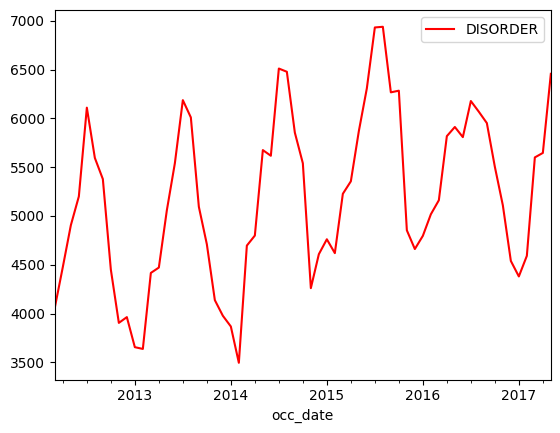

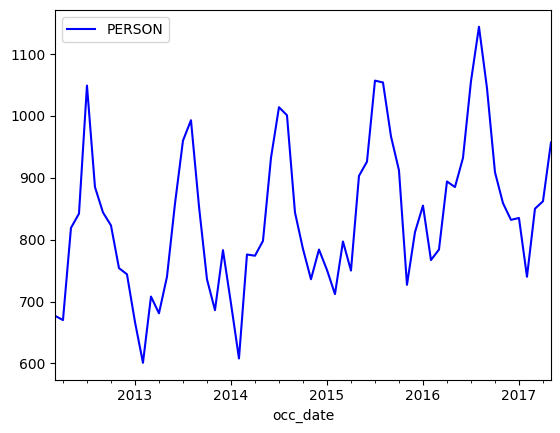

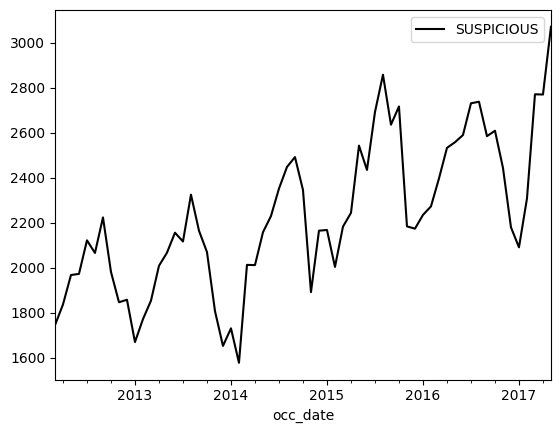

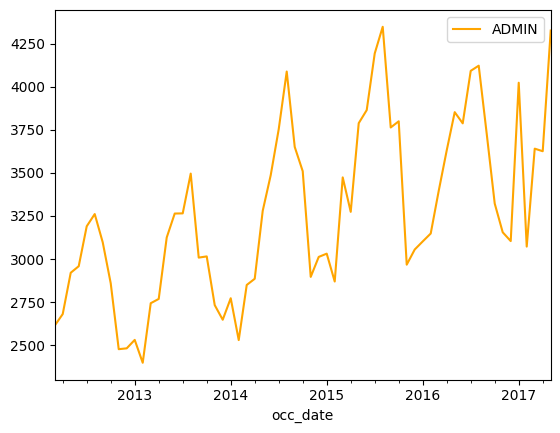

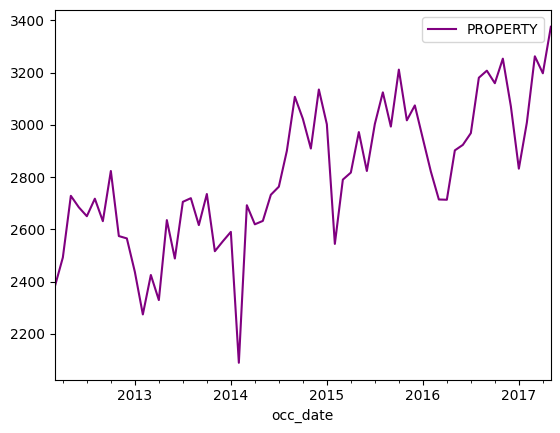

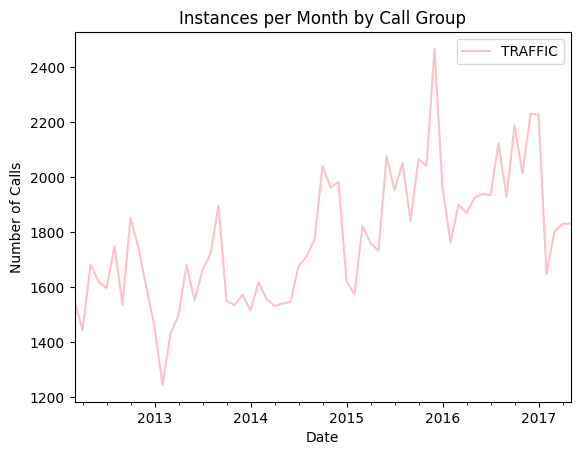

In [103]:
# data visualizations for 'DISORDER', 'PERSON', 'SUSPICIOUS', 'ADMIN', 'PROPERTY', 'TRAFFIC'

DISORDER.plot(y='count', x='occ_date', label='DISORDER', color='red')
PERSON.plot(y='count', x='occ_date', label='PERSON', color='blue')
SUSPICIOUS.plot(y='count', x='occ_date', label='SUSPICIOUS', color='black')
ADMIN.plot(y='count', x='occ_date', label='ADMIN', color='orange')
PROPERTY.plot(y='count', x='occ_date', label='PROPERTY', color='purple')
TRAFFIC.plot(y='count', x='occ_date', label='TRAFFIC', color='pink')
plt.title('Instances per Month by Call Group')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.show()

In [92]:
# Setting random seeds for reproducibility
# FROM HOMEWORK 4
seed_value = 42
os.environ["PYTHONHASHSEED"] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

l2_reg=0.001

In [107]:
# Test/Train Data Splitting -ARIMA 
# for 'DISORDER', 'PERSON', 'SUSPICIOUS', 'ADMIN', 'PROPERTY', 'TRAFFIC'

# Split point based on date, ~80/20 split
split_date = '2016-01-01'

for i in data_call_groups:
    globals()['train_data'+ i] = globals()[i][globals()[i]['occ_date'] < split_date]
    globals()['test_data'+ i] = globals()[i][globals()[i]['occ_date'] >= split_date]


,occ_date,count
46,2016-01,4796
47,2016-02,5017
48,2016-03,5161
49,2016-04,5818
50,2016-05,5912


c:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


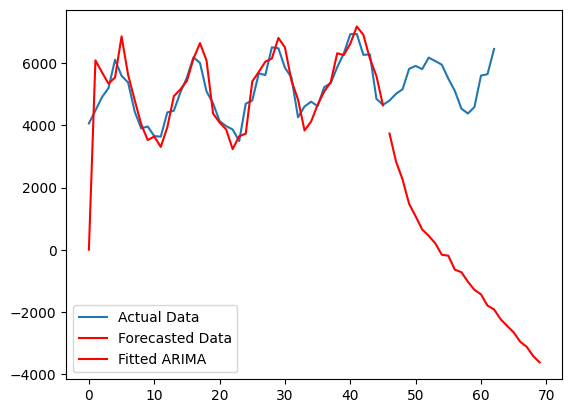

In [116]:
# ARIMA Model

# for i in data_call_groups:
#     globals()['model_'+ i] = ARIMA(globals()['train_data'+ i], order=(2, 2, 11))
#     globals()['fit_model_'+ i] = globals()['model_'+ i].fit()
#     globals()['yhat_'+ i] = globals()['fit_model_'+ i].forecast(steps=24)

#     plt.plot(globals()[i], label="Actual Data")
#     plt.plot(globals()['yhat_'+ i], color="red", label="Forecasted Data")

#     # Calculating the RMSE (Root Mean Squared Error)
#     globals()['rmse_'+ i] = mean_squared_error(globals()['test_data'+ i], globals()['yhat_'+ i], squared=False)
#     plt.title(f"RMSE: {globals()['rmse_'+ i]:.4f}")
#     plt.legend()
#     plt.show()



model = ARIMA(train_dataDISORDER['count'], order=(2, 2, 11))
results_ARIMA = model.fit()
yhat = results_ARIMA.forecast(steps=24)

plt.plot(DISORDER['count'], label="Actual Data")
plt.plot(yhat, color="red", label="Forecasted Data")
plt.plot(results_ARIMA.fittedvalues, color="red", label="Fitted ARIMA")

# Calculating the RMSE (Root Mean Squared Error)
# rmse = mean_squared_error(test_dataDISORDER['count'], yhat, squared=False)
# plt.title(f"RMSE: {rmse:.4f}")
plt.legend()
plt.show()

In [105]:
# Data Normalization (Neural Network)


,occ_date,count
46,2016-01,4796
47,2016-02,5017
48,2016-03,5161
49,2016-04,5818
50,2016-05,5912


In [95]:
# Prepare Data

In [96]:
# Data Normalization (Neural Network)

In [97]:
# LSTM Model Building

model = Sequential([
    LSTM(20, return_sequences=True, input_shape= [None, 1]),
    LSTM(20, return_sequences=True),
    TimeDistributed(Dense(10))
])

In [98]:
# Model Training

In [99]:
# Non-Rolling Predictions

In [100]:
# Rolling Predictions

In [101]:
# Model Evaluations